#Softmax Regression with Pytorch

In this code, I will hands on Machine Learning coding skill with Softmax Regression. 

The [Iris dataset](https://www.kaggle.com/datasets/uciml/iris) was used in R.A. Fisher's classic 1936 paper, The Use of Multiple Measurements in Taxonomic Problems, and can also be found on the UCI Machine Learning Repository.

It includes three iris species with 50 samples each as well as some properties about each flower. One flower species is linearly separable from the other two, but the other two are not linearly separable from each other.

The columns in this dataset are:

+ Id
+ SepalLengthCm
+ SepalWidthCm
+ PetalLengthCm
+ PetalWidthCm
+ Species


##[Some interview question](https://medium.com/analytics-vidhya/20-interview-questions-on-linear-regression-and-logistic-regression-ef4d341d2805)

In [1]:
!git clone https://github.com/NT-ThuHang/Hands_On_Machine_Learning_With_Pytorch.git
%cd /content/Hands_On_Machine_Learning_With_Pytorch

fatal: destination path 'Hands_On_Machine_Learning_With_Pytorch' already exists and is not an empty directory.
/content/Hands_On_Machine_Learning_With_Pytorch


##Library

In [2]:
#standard
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import plotly.express as px 

#prepare data
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

#modeling
import torch
from torch import nn, optim 
import torch.nn.functional as F 
from tqdm import tqdm 

#device 
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## EDA

In [3]:
dataset = pd.read_csv("./Dataset/Iris.csv")
dataset.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


### Information about data

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


##Correlation 

In [5]:
corr = dataset.corr()
corr.style.background_gradient()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
Id,1.000000,0.716676,-0.397729,0.882747,0.899759
SepalLengthCm,0.716676,1.000000,-0.109369,0.871754,0.817954
SepalWidthCm,-0.397729,-0.109369,1.000000,-0.420516,-0.356544
PetalLengthCm,0.882747,0.871754,-0.420516,1.000000,0.962757
PetalWidthCm,0.899759,0.817954,-0.356544,0.962757,1.000000


###Outlier detection

In [6]:
dataset.columns

Index(['Id', 'SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm',
       'Species'],
      dtype='object')

In [7]:
def boxplot(dataset, colors):
  for feature in dataset.columns:
    fig = px.box(dataset, y = feature, title="<b>"+feature, color = colors, 
                 boxmode = "group", template = "plotly_dark", points = "all")
    fig.update_layout(title_x = 0.5, title_font_size = 30, font_size = 15, font_color = "aqua")
    fig.show()
    
boxplot(dataset.drop(columns = "Species"), dataset["Species"])

###Convert Label

In [8]:
dataset.loc[dataset.Species == "Iris-setosa", "Species"] = 0
dataset.loc[dataset.Species == "Iris-versicolor", "Species"] = 1
dataset.loc[dataset.Species == "Iris-virginica", "Species"] = 2
dataset.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,0
1,2,4.9,3.0,1.4,0.2,0
2,3,4.7,3.2,1.3,0.2,0
3,4,4.6,3.1,1.5,0.2,0
4,5,5.0,3.6,1.4,0.2,0


In [16]:
X = dataset.drop(columns = ["Id", "Species"]).values
y = dataset["Species"].values.astype("int")
n_features = dataset.shape[1]-2
n_classes = len(np.unique(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, shuffle=True)

In [17]:
X_train = torch.tensor(X_train, dtype = torch.float).to(device) 
X_test = torch.tensor(X_test, dtype = torch.float).to(device) 
y_train = F.one_hot(torch.tensor(y_train), num_classes = n_classes)
y_train = torch.tensor(y_train, dtype = torch.float).to(device)
y_test = torch.tensor(y_test, dtype = torch.float).to(device) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [18]:
class IrisDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return self.X.size()[0]

  def __getitem__(self, idx):
    return [self.X[idx], self.y[idx]]


In [19]:
train_loader = DataLoader(IrisDataset(X_train, y_train), batch_size = 1, shuffle = True)

#Modeling

In [20]:
class SoftmaxRegression(nn.Module):
  def __init__(self, n_features, n_classes):
    super(SoftmaxRegression, self).__init__()
    self.linear = nn.Linear(n_features, n_classes)

  def forward(self, X):
    return F.softmax(self.linear(X))

In [21]:
#set up model
epochs = 500
model = SoftmaxRegression(n_features, n_classes).to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 1e-3)

In [22]:
losses = []
acc = []
for epoch in range(epochs):
  epoch_loss = []
  epoch_acc = []
  #inner loop
  for i, (data, label) in enumerate(train_loader):
    optimizer.zero_grad()

    #get sample
    data = data.to(device)
    label = label.to(device)

    #forward
    probas = model(data) 

    #loss
    loss = loss_func(probas, label)
    epoch_loss.append(loss.item()/data.size()[0])

    with torch.no_grad():
      label_truth = torch.argmax(label, dim = 1)
      label_pred = torch.argmax(probas, dim = 1)
      correct = torch.sum(label_truth == label_pred)
      epoch_acc.append(correct.item()/data.size()[0])

    #backward
    loss.backward()
    optimizer.step()
  
  losses.append(np.mean(epoch_loss))
  acc.append(np.mean(epoch_acc))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



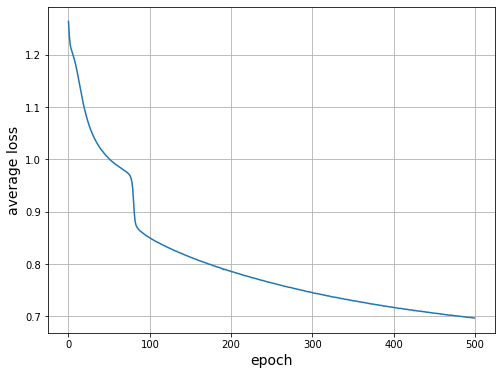

In [23]:
plt.figure(num=None, figsize=(8, 6))
plt.plot(losses)

# Adding some bells and whistles to the plot
plt.grid(True, which="both")
plt.xlabel('epoch', fontsize=14)
plt.ylabel('average loss', fontsize=14)
plt.show()

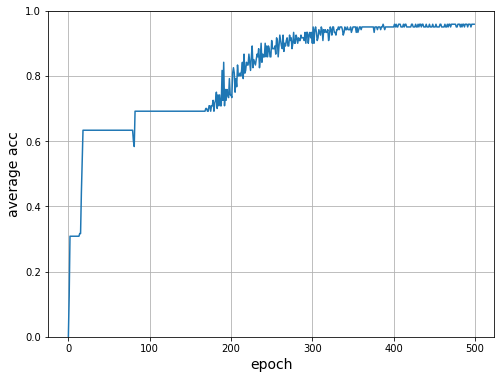

In [24]:
plt.figure(num=None, figsize=(8, 6))
plt.plot(acc)

# Adding some bells and whistles to the plot
plt.grid(True, which="both")
plt.ylim(0, 1)
plt.xlabel('epoch', fontsize=14)
plt.ylabel('average acc', fontsize=14)

plt.show()

##Testing Phase

In [31]:
with torch.no_grad():
  proba = model(X_test)
  label_pred = torch.argmax(proba, dim = 1)
  acc = torch.sum(label_pred == y_test) / y_test.size()[0]
  print(acc)

tensor(0.9667)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

